In [ ]:
#@markdown Utility function (run on each Runtime restart)

from IPython.display import clear_output
import os
import sys

def download_from_gdrive(gdrive_id, filename):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$gdrive_id -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$gdrive_id -O $filename && rm -rf /tmp/cookies.txt

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE:', DEVICE)

DEVICE: cuda


# 1. Data preparation

In [ ]:
#@markdown Load and process the file with data and checkpoints Google Drive IDs

GDRIVE_ID = '1S4QwcuznRxLlxkIT0Lb6vIuqDTib41B3'
FILE_IDS_NAME = 'file_ids.txt'

download_from_gdrive(GDRIVE_ID, FILE_IDS_NAME)

FILE_IDS = {}
with open(FILE_IDS_NAME, 'r') as f:
    for line in f:
        name, gid = line.strip().split('\t')
        FILE_IDS[name] = gid

clear_output()

In [ ]:
#@title Load codebase

LOAD_FROM_GITHUB = True #@param {type:"boolean"}

if LOAD_FROM_GITHUB:
    print('Loading code from GitHub')
    # will not work while repo is private
    !git clone https://github.com/mpiplani/CSCI-566-Project
else:
    # from Google Drive (the same code)
    print('Loading code from Google Drive')
    os.chdir('/content')
    fname = 'deephumor.zip'
    download_from_gdrive(FILE_IDS[fname], 'deephumor.zip')
    !unzip -o {fname}
    !rm -rf __MACOSX/

os.chdir('/content/CSCI-566-Project')
!pip install -r requirements.txt
clear_output()

print(f'Loaded code from {"GitHub" if LOAD_FROM_GITHUB else "Google Drive"}')

Loaded code from GitHub


In [ ]:
os.chdir('/content')
sys.path.append('/content/CSCI-566-Project')

## 1.1. Data

Load the dataset from Google Drive:

In [ ]:
DATA_DIR = 'memes900k'
CAPTIONS_FILE = os.path.join(DATA_DIR, 'captions_train.txt')

In [ ]:
#@title Load dataset

# full dataset
print('Loading the dataset from Google Drive')
fname = f'{DATA_DIR}.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {DATA_DIR}
clear_output()

## 1.2 Vocabulary

Before loading and testing the models it is necessary to build the token vocabularies used by the models.

Original vocavularies are built based on tokens the `captions_train.txt` file using `build_vocab_from_file` function. The function is deterministic and you will obtain the same vocabulary used during the experiments by setting `min_df=5`.

Vocabularies used by the models can also be loaded and built from Google Drive.

Set `LOAD_VOCABULARY = False` to built vocabularies from scratch. Overwise, the files will be loaded from Google Drive.


In [35]:
"""Vocabulary tools."""

from collections import Counter

SPECIAL_TOKENS = {
    'PAD': '<pad>',
    'UNK': '<unk>',
    'BOS': '<bos>',
    'EOS': '<eos>',
    'SEP': '<sep>',
    'EMPTY': '<emp>',
}


class Vocab:
    """Token vocabulary."""

    def __init__(self, tokens, special_tokens=tuple(SPECIAL_TOKENS.values())):
        tokens = list(sorted(filter(lambda x: x not in special_tokens, tokens)))
        self.tokens = list(special_tokens) + tokens
        self.stoi = {self.tokens[idx]: idx for idx in range(len(self.tokens))}
        self.itos = {idx: self.tokens[idx] for idx in range(len(self.tokens))}

    def __iter__(self):
        return iter(self.tokens)

    def __len__(self):
        return len(self.tokens)

    def save(self, filepath):
        with open(filepath, 'w') as f:
            for token in self.tokens:
                f.write(f'{token}\n')

    @staticmethod
    def load(filepath):
        tokens = []
        with open(filepath, 'r') as f:
            for line in f:
                token = line.strip('\n')
                tokens.append(token)
        return Vocab(tokens)


def build_vocab(documents, tokenizer, min_df=7):
    """Builds vocabulary of tokens from a collection of documents.
    Args:
        documents (list[str]): collection of documents
        tokenizer (Tokenizer): Tokenizer object
        min_df (int): minimum document frequency for tokens
    Returns:
        Vocab: vocabulary of tokens
    """
    token_counts = Counter()

    # tokenize and count unique tokens
    for text in documents:
        tokens = set(tokenizer.tokenize(text.lower()))
        token_counts.update(tokens)

    # filter by minimum document frequency
    tokens = [token for token, count in token_counts.items() if count >= min_df]

    # build vocabulary
    vocab = Vocab(tokens)

    return vocab


def build_vocab_from_file(captions_file, tokenizer, min_df=7):
    """Builds vocabulary from captions file.
    Args:
        captions_file (str): path to the file with captions
        tokenizer (Tokenizer): Tokenizer object
        min_df (int): minimum document frequency for tokens
    Returns:
        Vocab: vocabulary of tokens
    """

    captions = []
    with open(captions_file) as f:
        for line in f:
            _, _, caption = line.strip().split('\t')
            captions.append(caption)

    return build_vocab(captions, tokenizer, min_df=min_df)

In [36]:
"""Text Tokenizers."""
import abc
import re


class Tokenizer:
    """Abstract tokenizer."""

    @abc.abstractmethod
    def tokenize(self, text):
        pass


class WordPunctTokenizer:
    """WordPunctuation tokenizer."""

    token_pattern = re.compile(r"[<\w'>]+|[^\w\s]+")

    def tokenize(self, text):
        return self.token_pattern.findall(text)


class CharTokenizer:
    """Character-level tokenizer that preserves special tokens in `<>`."""

    token_pattern = re.compile(r"<\w+>|.")

    def tokenize(self, text):
        return self.token_pattern.findall(text)

In [37]:
#@title Word and Chararacter Vocab


LOAD_VOCABULARY = True #@param {type:"boolean"}
MIN_DF = 5 #@param {type:"integer"}

tokenizer_words = WordPunctTokenizer()
tokenizer_chars = CharTokenizer()

if LOAD_VOCABULARY:
    print('Loading vocabularies from Google Drive')

    fname = 'vocab.zip'
    download_from_gdrive(FILE_IDS[fname], fname)
    !unzip -o {fname}

    vocab_words = Vocab.load('vocab/vocab_words.txt')
    vocab_chars = Vocab.load('vocab/vocab_chars.txt')
    clear_output()

    print('Loaded vocabularies from Google Drive')
else:
    print(f'Building WordPunct Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_words = build_vocab_from_file(CAPTIONS_FILE, tokenizer_words, min_df=MIN_DF)

    print(f'Building Character Vocabulary from {CAPTIONS_FILE}, min_df={MIN_DF}')
    vocab_chars = build_vocab_from_file(CAPTIONS_FILE, tokenizer_chars, min_df=MIN_DF)


print('\nVocabulary sizes:')
print('WordVocab:', len(vocab_words))
print('CharVocab:', len(vocab_chars))

Loaded vocabularies from Google Drive

Vocabulary sizes:
WordVocab: 36541
CharVocab: 71


## 1.3 MemeDataset

Build Word- and Character-level `MemeDataset`s usign the defined vocabularies and tokenizers. 

Use `NUM_CLASSES` to limit the number of templates to load (max. is 300, for training the models only 200 were used).



In [39]:
import os

import torch
from PIL import Image
from torch.utils.data import Dataset




class MemeDataset(Dataset):
    """MemeGenerator dataset class."""

    def __init__(self, root, vocab, tokenizer=WordPunctTokenizer(),
                 split='train', num_classes=300, image_transform=None,
                 preload_images=True):
        assert split in ('train', 'val', 'test'), 'Incorrect data split'

        self.root = root
        self.split = split
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.image_transform = image_transform
        self.preload_images = preload_images

        self.num_classes = num_classes
        self._load_dataset()

    def _load_dataset(self):
        # load templates information
        fn_temp = os.path.join(self.root, 'templates.txt')
        assert os.path.exists(fn_temp), \
            f'Templates file {fn_temp} is not found'

        dir_imgs = os.path.join(self.root, 'images')
        assert os.path.isdir(dir_imgs), \
            f'Images directory {dir_imgs} is not found'

        self.templates = {}
        self.images = {}
        with open(fn_temp, 'r') as f:
            for line in f:
                label, _, url = line.strip().split('\t')
                filename = url.split('/')[-1]
                self.templates[label] = os.path.join(dir_imgs, filename)

                # preaload images and apply transforms
                if self.preload_images:
                    img = Image.open(self.templates[label])
                    if self.image_transform is not None:
                        img = self.image_transform(img)
                    self.images[label] = img
                else:
                    self.images[label] = self.templates[label]

                if len(self.templates) == self.num_classes:
                    break

        # load captions
        fn_capt = os.path.join(self.root, f'captions_{self.split}.txt')
        assert os.path.exists(fn_capt), \
            f'Captions file {fn_capt} is not found'

        self.captions = []
        with open(fn_capt, 'r') as f:
            for i, line in enumerate(f):
                label, _, caption = line.strip().split('\t')
                if label in self.templates:
                    self.captions.append((label, caption))

    def _preprocess_text(self, text):
        # tokenize
        tokens = self.tokenizer.tokenize(text.lower())

        # replace with `UNK`
        tokens = [tok if tok in self.vocab.stoi else SPECIAL_TOKENS['UNK'] for tok in tokens]

        # add `EOS`
        tokens += [SPECIAL_TOKENS['EOS']]

        # convert to ids
        tokens = [self.vocab.stoi[tok] for tok in tokens]

        return tokens

    def __getitem__(self, idx):
        label, caption = self.captions[idx]
        img = self.images[label]

        # label and caption tokens
        label = torch.tensor(self._preprocess_text(label)).long()
        caption = torch.tensor(self._preprocess_text(caption)).long()

        # image transform
        if not self.preload_images:
            img = Image.open(img)
            if self.image_transform is not None:
                img = self.image_transform(img)

        return label, caption, img

    def __len__(self):
        return len(self.captions)

In [40]:
#@title Build `MemeDataset`



# use this to limit the dataset size (300 classes in total)
NUM_CLASSES = 200 #@param {type:"slider", min:1, max:300, step:1}  
PAD_IDX = vocab_words.stoi['<pad>']

from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

splits = ['train', 'val', 'test']

datasets_words = {
    # WORD-LEVEL
    split: MemeDataset(DATA_DIR, vocab_words, tokenizer_words, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

datasets_chars = {
    # CHAR-LEVEL
    split: MemeDataset(DATA_DIR, vocab_chars, tokenizer_chars, image_transform=image_transform,
                       num_classes=NUM_CLASSES, split=split, preload_images=True)
    for split in splits
}

# 2. Models

In [43]:
"""Image and Text Encoder models."""
import torch
from torch import nn
from torchvision import models


class ImageEncoder(nn.Module):
    """ResNet-based [1] image encoder.
    Encodes an image into a `emb_size` vector.
    If `spatial_features=True`, encoder also builds spatial features
    of the image based on the output of the last block of ResNet.
    The shape of spatial features is `[k x k, emb_size]`
    Note: `nn.Linear` layer is shared for global and spatial encodings.
    References:
        [1]: "Deep Residual Learning for Image Recognition", https://arxiv.org/abs/1512.03385
    """

    def __init__(self, emb_dim=256, dropout=0.2, spatial_features=False):
        """Initializes ImageEncoder.
        Args:
            emb_dim (int): dimensions of the output embedding
            dropout (float): dropout for the encoded features
            spatial_features (bool): whether compute spatial features or not
        """
        super().__init__()

        self.spatial_features = spatial_features

        resnet = models.resnet50(pretrained=True)
        for p in resnet.parameters():
            p.requires_grad = False
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.avgpool = resnet.avgpool

        # embedding layer
        self.linear = nn.Linear(resnet.fc.in_features, emb_dim)
        self.bn = nn.BatchNorm1d(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, images):
        """
        Args:
            images (torch.Tensor): input images of shape `[bs, width, height]`
        Returns:
            torch.Tensor: global image embedding of shape `[bs, emb_dim]` if `self.spatial_features=False`,
                (`self.spatial_features=True`) spatial image embeddings of shape `[bs, k_w x k_h, emb_dim]`
        """
        # ResNet features
        features = self.resnet(images)
        bs, dim = features.shape[:2]

        # global image embedding
        x = self.avgpool(features).reshape(bs, -1)
        emb = self.dropout(self.bn(self.linear(x)))

        # spatial features
        if self.spatial_features:
            x = features.reshape(bs, dim, -1)
            x = x.transpose(2, 1)  # (B, D, N) -> (B, N, D)
            spatial_emb = self.dropout(self.linear(x))
            return emb, spatial_emb

        return emb


class LabelEncoder(nn.Module):
    """Label encoder.
    Encodes text labels into a single embedding of size `emb_dim`.
    Label Encoder 2 from [1].
    References:
        [1]: "Dank Learning: Generating Memes Using Deep Neural Networks", https://arxiv.org/abs/1806.04510
    """

    def __init__(self, num_tokens, emb_dim=256, dropout=0.2):
        """Initializes LabelEncoder.
        Args:
            num_tokens: number of tokens in the vocabulary
            emb_dim (int): dimensions of the output embedding
            dropout (float): dropout for the encoded features
        """
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, labels):
        """
        Args:
            labels (torch.Tensor): input text labels of shape `[bs, seq_len]`
        Returns:
            torch.Tensor: average label embedding of shape `[bs, emb_dim]`
        """
        emb = self.embedding(labels).mean(dim=1)
        emb = self.dropout(emb)
        return emb


class ImageLabelEncoder(nn.Module):
    """ImageLabel encoder.
    Encodes images and text labels into a single embedding of size `emb_dim`.
    """

    def __init__(self, num_tokens, emb_dim=256, dropout=0.2):
        """Initializes LabelEncoder.
        Args:
            num_tokens: number of tokens in the vocabulary
            emb_dim (int): dimensions of the output embedding
            dropout (float): dropout for the encoded features
        """
        super().__init__()
        self.image_encoder = ImageEncoder(emb_dim, dropout)
        self.label_encoder = LabelEncoder(num_tokens, emb_dim, dropout)
        self.linear = nn.Linear(2 * emb_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, images, labels):
        """
        Args:
            images (torch.Tensor): input images of shape `[bs, width, height]`
            labels (torch.Tensor): input text labels of shape `[bs, seq_len]`
        Returns:
            torch.Tensor: combined image-label embedding of shape `[bs, emb_dim]`
        """
        image_emb = self.image_encoder(images)
        label_emb = self.label_encoder(labels)

        emb = torch.cat([image_emb, label_emb], dim=1)
        emb = self.dropout(self.linear(emb))

        return emb

In [44]:
import torch


class BeamSearchHelper:
    """Helper class with common functions for beam search sampling."""

    def __init__(self, temperature=1.0, beam_size=10, top_k=50,
                 unk_index=1, eos_index=3, device='cuda'):
        assert beam_size <= top_k, '`beam_size` should be less than `top_k`'

        self.temperature = temperature
        self.beam_size = beam_size
        self.top_k = top_k
        self.unk_index = unk_index
        self.eos_index = eos_index
        self.device = device
        self._build_has_ended_variables()

    def _build_has_ended_variables(self):
        """Returns flags and masks for monitoring if generation has ended."""
        # flags showing if sequence has ended
        self.has_ended = torch.tensor([False] * self.beam_size).to(self.device)

        # masks for filtering out predictions for ended/not_ended sequences
        self._n_copies_has_ended = torch.tensor([[self.beam_size], [1]]).to(self.device)
        self._mask_has_ended = torch.stack(
            [torch.tensor([True] * self.beam_size),
             torch.tensor([True] + [False] * (self.beam_size - 1))],
            dim=0
        ).to(self.device)

    def filter_top_k(self, logits):
        """Filters `top_k` logit values by zeroing out others."""
        filter_ind = logits < torch.topk(logits, self.top_k, dim=-1).values[:, -1].unsqueeze(-1)
        filter_ind[:, self.unk_index] = True  # zero out unk token
        logits[filter_ind] = float('-inf')
        return logits

    def sample_k_indices(self, logits, k=None):
        """Samples `beam_size` indices for each sequence in the batch."""
        # compute probabilities
        p_next = torch.softmax(logits / self.temperature, dim=-1)

        # sample values
        k = self.beam_size if k is None else k
        sample_ind = torch.multinomial(p_next, k)

        return sample_ind

    @staticmethod
    def filter_by_indices(values, indices):
        sample_val = torch.gather(values, 1, indices)
        return sample_val

    def process_logits(self, logits, sample_seq, sample_val):
        """Main logic of beam search sampling step.
        Steps:
            - filter `top_k` logit scores
            - filter out predictions for already ended sequences
            - check if new predictions end sequence
            - update `has_ended` indices
        Args:
            logits (torch.Tensor): logit predictions, outputs of the classifier layer
            sample_seq (torch.Tensor): `beam_size` sequences from the previous sampling step
            sample_val (torch.Tensor): scores for the sequences from the previous sampling step
        Returns:
            (prev_seqs, prev_vals), (new_ind, new_val):
                expanded sequences and their scores from the previous sampling step
                + new candidate predictions and their scores
        """
        # filter `top_k` values
        logits = self.filter_top_k(logits)

        # sample `beam` sequences for each branch
        new_ind = self.sample_k_indices(logits, k=self.beam_size)
        new_val = self.filter_by_indices(logits, new_ind).log_softmax(-1)
        new_ind, new_val = new_ind.flatten(), new_val.flatten()

        # numbers of repeat_interleave copies (if ended, only a single copy)
        n_copies = self._n_copies_has_ended[self.has_ended.long(), :].flatten()

        # mask for unique rows
        unique_rows = self._mask_has_ended[self.has_ended.long(), :].flatten()

        # filter values
        new_ind = new_ind[unique_rows]
        new_val = new_val[unique_rows]

        # check if the sequences already ended
        # (no need to predict and evaluate new scores)
        self.has_ended = torch.repeat_interleave(self.has_ended, n_copies, dim=0)
        new_ind[self.has_ended], new_val[self.has_ended] = 0, 0.

        # update `had_ended` based on new predictions
        self.has_ended = self.has_ended | (new_ind == self.eos_index)

        # repeat current sampled sequences
        prev_seqs = torch.repeat_interleave(sample_seq, n_copies, dim=0)
        prev_vals = torch.repeat_interleave(sample_val, n_copies, dim=0)

        if len(prev_seqs.size()) == 1:
            prev_seqs = prev_seqs.unsqueeze(0)
            prev_vals = prev_vals.unsqueeze(0)

        return (prev_seqs, prev_vals), (new_ind, new_val)

    def all_ended(self):
        """Returns bool indicating if all sequences have ended."""
        return torch.all(self.has_ended)


In [45]:
"""RNN-based models."""
import torch
from torch import nn



class LSTMDecoder(nn.Module):
    """LSTM-based decoder."""

    def __init__(self, num_tokens, emb_dim=256, hidden_size=512,
                 num_layers=3, dropout=0.1, embedding=None):

        super(LSTMDecoder, self).__init__()

        self.num_tokens = num_tokens

        if embedding is not None:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(num_tokens, emb_dim)

        self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers, batch_first=True,
                            dropout=(0 if num_layers == 1 else dropout))

        self.classifier = nn.Linear(hidden_size, num_tokens)

    def forward(self, image_emb, captions, lengths=None):
        # caption tokens embeddings
        token_emb = self.embedding(captions)

        # image embedding + token embeddings
        x = torch.cat((image_emb.unsqueeze(1), token_emb), dim=1)

        if lengths is None:
            lengths = torch.tensor(x.size(1)).repeat(x.size(0))

        # LSTM ouputs
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        # mapping into `num_tokens`
        outputs = self.classifier(outputs)

        return outputs

    def generate(self, image_emb, caption=None, max_len=25,
                 temperature=1.0, beam_size=10, top_k=50, eos_index=3):
        """Generates text tokens based on the image embedding.
        Args:
            image_emb (torch.Tensor): image embedding of shape `[1, emb_dim]`
            caption (torch.Tensor, optional): beginning tokens of the caption of shape `[1, seq_len]`
            max_len (int): maximum length of the caption
            temperature (float): temperature for softmax over logits
            beam_size (int): number of maintained branches at each step
            top_k (int): number of the most probable tokens to consider during sampling
            eos_index (int): index of the EOS (end-of-sequence) token
        Returns:
            torch.Tensor: generated caption tokens of shape `[1, min(output_len, max_len)]`
        """

        # beam search sampling helper
        helper = BeamSearchHelper(
            temperature=temperature, beam_size=beam_size,
            top_k=top_k, eos_index=eos_index,
            device=image_emb.device
        )

        # process caption tokens if present
        if caption is None:
            inputs = image_emb
        else:
            token_emb = self.embedding(caption)
            inputs = torch.cat([image_emb, token_emb], dim=1)

        # run LSTM over the inputs and predict the next token
        outputs, (h, c) = self.lstm(inputs)
        logits = self.classifier(outputs[:, -1, :])

        # repeat hidden state `beam` times
        h, c = h.repeat((1, beam_size, 1)), c.repeat((1, beam_size, 1))

        # filter `top_k` values
        logits = helper.filter_top_k(logits)

        # compute probabilities and sample k values
        sample_ind = helper.sample_k_indices(logits, k=beam_size)
        sample_val = helper.filter_by_indices(logits, sample_ind).log_softmax(-1)
        sample_ind, sample_val = sample_ind.T, sample_val.T

        # define total prediction sequences
        sample_seq = sample_ind.clone().detach()
        if caption is not None:
            sample_seq = torch.cat([caption.repeat(beam_size, 1), sample_seq], dim=1)

        # reusable parameters
        beam_copies = torch.tensor([beam_size] * beam_size).to(outputs.device)

        # update `has_ended` index
        helper.has_ended = (sample_ind == eos_index).view(-1)

        for i in range(sample_seq.size(1), max_len):
            # predict the next time step
            inputs = self.embedding(sample_ind)
            outputs, (h, c) = self.lstm(inputs, (h, c))
            logits = self.classifier(outputs[:, -1, :])

            (prev_seqs, prev_vals), (new_ind, new_val) = helper.process_logits(
                logits, sample_seq, sample_val
            )

            # create candidate sequences and compute their probabilities
            cand_seq = torch.cat((prev_seqs, new_ind.unsqueeze(0).T), -1)
            cand_val = prev_vals.flatten() + new_val

            # sample `beam` sequences
            filter_ind = helper.sample_k_indices(cand_val, k=beam_size)

            # update total sequences and their scores
            sample_val = cand_val[filter_ind]
            sample_seq = cand_seq[filter_ind]
            sample_ind = sample_seq[:, -1].unsqueeze(-1)

            # filter `has_ended` flags
            helper.has_ended = helper.has_ended[filter_ind]

            # check if every branch has ended
            if helper.all_ended():
                break

            # repeat hidden state `beam` times and filter by sampled indices
            h = torch.repeat_interleave(h, beam_copies, dim=1)
            c = torch.repeat_interleave(c, beam_copies, dim=1)
            h, c = h[:, filter_ind, :], c[:, filter_ind, :]

        # sample output sequence
        ind = helper.sample_k_indices(sample_val, k=1)
        output_seq = sample_seq[ind, :].squeeze()

        return output_seq

In [46]:
"""Image captioning models."""
import torch
from torch import nn




class CaptioningLSTM(nn.Module):
    """LSTM-based image captioning model.
    Encodes input images into a embeddings of size `emb_dim`
    and passes them as the first token to the caption generation decoder.
    """
    def __init__(self, num_tokens, emb_dim=256, hidden_size=512, num_layers=2,
                 enc_dropout=0.3, dec_dropout=0.1):
        super(CaptioningLSTM, self).__init__()

        self.encoder = ImageEncoder(
            emb_dim=emb_dim,
            dropout=enc_dropout
        )

        self.decoder = LSTMDecoder(
            num_tokens=num_tokens,
            emb_dim=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dec_dropout,
        )

        # hyperparameters dictionary
        self._hp = {
            'num_tokens': num_tokens,
            'emb_dim': emb_dim,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'enc_dropout': enc_dropout,
            'dec_dropout': dec_dropout,
        }

    def forward(self, images, captions, lengths=None):
        emb = self.encoder(images)
        out = self.decoder(emb, captions, lengths)

        return out

    def generate(self, image, caption=None, max_len=25,
                 temperature=1.0, beam_size=10, top_k=50, eos_index=3):
        """Generates caption for an image.
        Args:
            image (torch.Tensor): input image of shape `[1, width, height]`
            caption (torch.Tensor, optional): beginning tokens of the caption of shape `[1, seq_len]`
            max_len (int): maximum length of the caption
            temperature (float): temperature for softmax over logits
            beam_size (int): number of maintained branches at each step
            top_k (int): number of the most probable tokens to consider during sampling
            eos_index (int): index of the EOS (end-of-sequence) token
        Returns:
            torch.Tensor: generated caption tokens of shape `[1, min(output_len, max_len)]`
        """

        # get image embedding
        image_emb = self.encoder(image).unsqueeze(1)

        sampled_ids = self.decoder.generate(
            image_emb, caption=caption,
            max_len=max_len, temperature=temperature,
            beam_size=beam_size, top_k=top_k, eos_index=eos_index
        )

        return sampled_ids

    def save(self, ckpt_path):
        """Saves the model's state and hyperparameters."""
        torch.save(
            {'model': self.state_dict(), 'hp': self._hp},
            ckpt_path
        )

    @staticmethod
    def from_pretrained(ckpt_path):
        """Loads and builds the model from the checkpoint file."""
        ckpt = torch.load(ckpt_path, map_location='cpu')
        hp = ckpt['hp']

        model = CaptioningLSTM(
            num_tokens=hp['num_tokens'],
            emb_dim=hp['emb_dim'],
            hidden_size=hp['hidden_size'],
            num_layers=hp['num_layers'],
            enc_dropout=hp['enc_dropout'],
            dec_dropout=hp['dec_dropout'],
        )
        model.load_state_dict(ckpt['model'])
        return model


class CaptioningLSTMWithLabels(nn.Module):
    """LSTM-based image captioning model with label inputs.
    Uses image and text label to condition the decoder.
    Encoder build combined embeddings of size `emb_dim` for input images and text labels
    and passes them as the first token to the caption generation decoder.
    """
    def __init__(self, num_tokens, emb_dim=256, hidden_size=512, num_layers=2,
                 enc_dropout=0.3, dec_dropout=0.1):
        super(CaptioningLSTMWithLabels, self).__init__()

        self.encoder = ImageLabelEncoder(
            num_tokens=num_tokens,
            emb_dim=emb_dim,
            dropout=enc_dropout
        )

        self.decoder = LSTMDecoder(
            num_tokens=num_tokens,
            emb_dim=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dec_dropout,
            embedding=self.encoder.label_encoder.embedding
        )

        # hyperparameters dictionary
        self._hp = {
            'num_tokens': num_tokens,
            'emb_dim': emb_dim,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'enc_dropout': enc_dropout,
            'dec_dropout': dec_dropout,
        }

    def forward(self, images, captions, lengths, labels):
        emb = self.encoder(images=images, labels=labels)
        out = self.decoder(emb, captions, lengths)

        return out

    def generate(self, image, label, caption=None, max_len=25,
                 temperature=1.0, beam_size=10, top_k=50, eos_index=3):
        """Generates caption for an image based on the text label.
        Args:
            image (torch.Tensor): input image of shape `[1, width, height]`
            label: (torch.Tensor): text label for the image `[1, label_len]`
            caption (torch.Tensor, optional): beginning tokens of the caption of shape `[1, seq_len]`
            max_len (int): maximum length of the caption
            temperature (float): temperature for softmax over logits
            beam_size (int): number of maintained branches at each step
            top_k (int): number of the most probable tokens to consider during sampling
            eos_index (int): index of the EOS (end-of-sequence) token
        Returns:
            torch.Tensor: generated caption tokens of shape `[1, min(output_len, max_len)]`
        """

        # get image embedding
        image_emb = self.encoder(image, label).unsqueeze(1)

        sampled_ids = self.decoder.generate(
            image_emb, caption=caption,
            max_len=max_len, temperature=temperature,
            beam_size=beam_size, top_k=top_k, eos_index=eos_index
        )

        return sampled_ids

    def save(self, ckpt_path):
        """Saves the model's state and hyperparameters."""
        torch.save(
            {'model': self.state_dict(), 'hp': self._hp},
            ckpt_path
        )

    @staticmethod
    def from_pretrained(ckpt_path):
        """Loads and builds the model from the checkpoint file."""
        ckpt = torch.load(ckpt_path, map_location='cpu')
        hp = ckpt['hp']

        model = CaptioningLSTMWithLabels(
            num_tokens=hp['num_tokens'],
            emb_dim=hp['emb_dim'],
            hidden_size=hp['hidden_size'],
            num_layers=hp['num_layers'],
            enc_dropout=hp['enc_dropout'],
            dec_dropout=hp['dec_dropout'],
        )
        model.load_state_dict(ckpt['model'])
        return model


In [47]:
#@markdown Model loading utilities


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_and_build_model(gdrive_id, ckpt_path, model_class):
    print('Downloading model weights from Google Drive')
    download_from_gdrive(gdrive_id, ckpt_path)
    clear_output()
    print('Downloaded model weights')

    print(f'Building {model_class.__name__} model')
    model = model_class.from_pretrained(ckpt_path).to(DEVICE)
    print(f'Built and loaded {model_class.__name__} model from {ckpt_path}')
    print('# parameters:', count_parameters(model))

    return model

FILE_TO_CLASS = {
    'LSTMDecoderWords.best.pth': CaptioningLSTM,
    
    'LSTMDecoderWithLabelsWords.best.pth': CaptioningLSTMWithLabels,
    
}

IMPORTANT: if some cell in this section crashed, run it again, it should be fine

## 2.1. Word-based models

### 2.1.1. LSTM Decoder

In [48]:
#@markdown Load and build `w_lstm_model`

ckpt_path = 'LSTMDecoderWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTM model
Built and loaded CaptioningLSTM model from LSTMDecoderWords.best.pth
# parameters: 44808381


### 2.1.2. LSTM Decoder with labels

In [49]:
#@markdown Load and build `w_lstm_model_labels`

ckpt_path = 'LSTMDecoderWithLabelsWords.best.pth'
gdrive_id = FILE_IDS[ckpt_path]
model_class = FILE_TO_CLASS[ckpt_path]

w_lstm_model_labels = load_and_build_model(gdrive_id, ckpt_path, model_class)

Downloaded model weights
Building CaptioningLSTMWithLabels model
Built and loaded CaptioningLSTMWithLabels model from LSTMDecoderWithLabelsWords.best.pth
# parameters: 45333181


# 3. Meme Generation

In [50]:
IMG_DIR = 'images_inference'

fname = 'inference.zip'
download_from_gdrive(FILE_IDS[fname], fname)
!unzip -o {fname}
clear_output()

In [51]:
import re

import torch


PUNCT_PATTERN = re.compile(r"( )([!#$%&\()*+,\-.\/:;<=>?@\\^{|}~]+)")


def text_to_seq(text, vocab, tokenizer):
    """Transforms string text into a tensor of tokens.
    Args:
        text (str): text input
        vocab (Vocab): token vocabulary
        tokenizer (Tokenizer): text tokenizer
    Returns:
        Torch.tensor: sequence of tokens of size (1, seq_len)
    """

    # tokenize
    tokens = tokenizer.tokenize(text.lower())

    # replace with `UNK`
    tokens = [tok if tok in vocab.stoi else SPECIAL_TOKENS['UNK'] for tok in tokens]

    # convert to ids
    tokens = [vocab.stoi[tok] for tok in tokens]

    return torch.tensor(tokens).unsqueeze(0)


def seq_to_text(seq, vocab, delimiter=' '):
    """Transforms torch tensor of tokens into a text.
    Args:
        seq (Torch.tensor): sequence of tokens of size (1, seq_len)
        vocab (Vocab): token vocabulary
        delimiter (str): delimiter between text tokens
    Returns:
        str: transformed text
    """

    # find the end the sequence
    eos_ids = torch.where(seq == vocab.stoi[SPECIAL_TOKENS['EOS']])[0]
    if len(eos_ids) > 0:
        seq = seq[:eos_ids[0]]

    # convert tokens indices into text tokens
    tokens = list(map(lambda x: vocab.itos[x], seq.cpu().numpy()))

    # join text tokens
    text = delimiter.join(tokens)

    return text


def split_caption(text, num_blocks=None):
    """Splits text caption into blocks according to the special tokens.
    Args:
        text (str): input caption text
        num_blocks (int): number of blocks to return (`None` for keeping all)
    Returns:
        List[str]: a list of text blocks
    """

    def _clean_text_block(text_block):
        text_block = re.sub(r'<\w+>', '', text_block)
        text_block = re.sub(r'^\s+', '', text_block)
        text_block = re.sub(r'\s+$', '', text_block)
        text_block = PUNCT_PATTERN.sub('\\2', text_block)
        return text_block

    text_blocks = text.split(SPECIAL_TOKENS['SEP'])

    # clean blocks from any special tokens and padding spaces
    text_blocks = [_clean_text_block(t) for t in text_blocks]

    if num_blocks is None:
        num_blocks = len(text_blocks)
    elif len(text_blocks) < num_blocks:
        text_blocks += [''] * (num_blocks - len(text_blocks))

    return text_blocks[:num_blocks]

In [52]:
import numpy as np
from PIL import ImageFont, ImageDraw
from copy import deepcopy


MEME_FONT_PATH = '../../fonts/impact.ttf'


def memeify_image(img, top='', bottom='', font_path=MEME_FONT_PATH):
    """Adds top and bottom captions to an image.
    Args:
        img (PIL.Image): input image
        top (str): top caption text
        bottom (str): top caption text
        font_path (str): path to font
    Returns:
        PIL.Image: captioned image
    """
    # do not change existing image
    img = deepcopy(img)

    # initial font
    font = _get_initial_font(img, texts=[top, bottom], font_path=font_path)

    # split texts into lines
    top_lines = split_to_lines(img, top, font)
    bottom_lines = split_to_lines(img, bottom, font)

    # adjust the font
    font = _get_final_font(img, [top_lines, bottom_lines], font_path=font_path)

    # caption image with both texts
    img = caption_image(img, top_lines, font, 'top')
    img = caption_image(img, bottom_lines, font, 'bottom')

    return img


def get_maximal_font(img, text, font_size=64, text_width=0.94, font_path=MEME_FONT_PATH):
    """Computes the font of maximal size that fits the text.
    Args:
        img (PIL.Image): input image
        text (str): text to fit into image
        font_size (int): initial font size
        text_width (float): text width ratio with respect to image width
        font_path (str): path to font
    Returns:
        PIL.ImageFont: optimal font
    """
    font = ImageFont.truetype(font_path, font_size)
    w, h = font.getsize(text)

    # find the biggest font size that works
    while w > img.width * text_width:
        font_size = font_size - 1
        font = ImageFont.truetype(font_path, font_size)
        w, h = font.getsize(text)

    return font


def _get_initial_font(img, texts, max_chars=20, font_path=MEME_FONT_PATH):
    """Compute initial font of maximal size based of texts.
    Args:
        img (PIL.Image): input image
        texts (List[str]): list of texts
        max_chars (int): maximum number of characters in a line
        font_path (str): path to font
    Returns:
        PIL.ImageFont: optimal font
    """
    # compute the maximum number of characters in a line
    max_len = max(map(len, texts))
    max_len = max_len if max_len < max_chars else max_chars
    longest_text = 'G' * max_len

    # get initial font size from image dimensions
    font_size = int(img.height / 5.4)

    # get maximal font for the initial text
    font = get_maximal_font(img, longest_text, font_size, font_path=font_path)

    return font


def _get_final_font(img, text_lines, font_path=MEME_FONT_PATH):
    """Compute final font of maximal size based of texts split into lines.
    Args:
        img (PIL.Image): input image
        text_lines (List[List[str]]): list of list of text lines
        font_path (str): path to font
    Returns:
        PIL.ImageFont: optimal font
    """
    # initial font size
    font_size = int(img.height / 5.4) // max(map(len, text_lines))
    font = ImageFont.truetype(font_path, font_size)

    # find the text with the highest occupied width
    text_lines = [text for lines in text_lines for text in lines]
    lengths = list(map(lambda x: font.getsize(x)[0], text_lines))
    longest_text = text_lines[np.argmax(lengths)]

    # get maximal font for the text with highest width
    font = get_maximal_font(img, longest_text, font_size, font_path=font_path)

    return font


def split_to_lines(img, text, font):
    """Splits text into lines to fit the image with a given font.
    Args:
        img (PIL.Image): input image
        text (str): input text
        font (PIL.ImageFont): text font
    Returns:
        List[str]: list of text lines
    """
    draw = ImageDraw.Draw(img)
    text = text.replace('', '').upper()
    w, h = draw.textsize(text, font)  # measure the size the text will take

    # compute the number of lines
    line_count = 1
    if w > img.width:
        line_count = w // img.width + 1

    lines = []
    if line_count > 1:
        # cut text into lines preserving words

        last_cut = 0
        is_last = False

        for i in range(0, line_count):
            cut = (len(text) // line_count) * i if last_cut == 0 else last_cut

            if i < line_count - 1:
                next_cut = (len(text) // line_count) * (i + 1)
            else:
                next_cut = len(text)
                is_last = True

            # make sure we don't cut words in half
            if not (next_cut == len(text) or text[next_cut] == " "):
                while text[next_cut] != " ":
                    next_cut += 1

            line = text[cut:next_cut].strip()

            # does line still fit?
            w, h = draw.textsize(line, font)
            if not is_last and w > img.width * 0.95:
                next_cut -= 1
                while text[next_cut] != " ":
                    next_cut -= 1

            last_cut = next_cut
            lines.append(text[cut:next_cut].strip())
    else:
        lines.append(text)

    return lines


def caption_image(img, text_lines, font, pos='top'):
    """Captions the image with text.
    Args:
        img (PIL.Image): input image
        text_lines (List[str]): list of text lines
        font (PIL.ImageFont): text font
        pos (str): position of text (`top` or `bottom`)
    Returns:
        PIL.Image: captioned image
    """
    draw = ImageDraw.Draw(img)
    w, h = draw.textsize(text_lines[0], font)  # measure the size the text will take

    # text border size
    border_size = font.size // 18

    # compute the position of text on y-axis
    last_y = -h
    if pos == 'bottom':
        last_y = img.height * 0.987 - h * (len(text_lines) + 1) - border_size

    # draw text lines
    for line in text_lines:
        w, h = draw.textsize(line, font)
        x = img.width / 2 - w / 2
        y = last_y + h

        # add borders of black color
        for xx in range(-border_size, border_size + 1):
            for yy in range(-border_size, border_size + 1):
                draw.text((x + xx, y + yy), line, (0, 0, 0), font=font)

        # add text in white
        draw.text((x, y), line, (255, 255, 255), font=font)

        last_y = y

    return img

In [53]:
#@title Meme generation and captioning function

from PIL import Image


FONT_PATH = 'CSCI-566-Project/fonts/impact.ttf'

def get_a_meme(model, img_torch, img_pil, caption, T=1., beam_size=7, top_k=50, 
               labels = None, mode = 'word', device=DEVICE):
    if mode == 'word':
        vocabulary = vocab_words
        datasets = datasets_words
        delimiter=' '
        max_len = 32
    else:
        vocabulary = vocab_chars
        datasets = datasets_chars
        delimiter=''
        max_len = 128
    
    model.eval()
    if caption is not None:
        caption_tensor = torch.tensor(datasets['train']._preprocess_text(caption)[:-1]).unsqueeze(0).to(device) 
    else:
        caption_tensor = None

    if labels is None:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    else:
        with torch.no_grad():
            output_seq = model.generate(
                image=img_torch, label=labels, caption=caption_tensor,
                max_len=max_len, beam_size=beam_size, temperature=T, top_k=top_k
            )
    
    pred_seq = output_seq
    text = seq_to_text(pred_seq, vocab=vocabulary, delimiter=delimiter)

    top, bottom = split_caption(text, num_blocks=2)
    # print(top)
    # print(bottom)

    return memeify_image(img_pil, top, bottom, font_path=FONT_PATH)

# GENERATE

You can either use images from the dataset or use images of your own (unseen during the traing). For the latter download your image to the Images_inference folder. It is also possible to take images from that folder. 

One more option is to select the beginning of your future generated meme, and by doing so inserting some context into the model. To do so change `caption = None` to your sring.

## Images from the dataset

In the cell below you can input the corresonding `label` of the template, the full list of templates is in memes900k/templates.txt. You can use labels only in models with that feature, namely `ch_lstm_model_labels`, `w_lstm_model_labels`. To do so, during generation in function `get_a_meme` write `labels=labels`.

In [84]:
# Image from dataset
label = 'Awkward Seal' 
labels = torch.tensor(datasets_words['train']._preprocess_text(label)).unsqueeze(0).cuda()
img_torch = datasets_words['train'].images[label]
img_pil = Image.open(datasets_words['train'].templates[label])

img_torch = img_torch.unsqueeze(0).cuda()
caption = 'dog play toy toy'

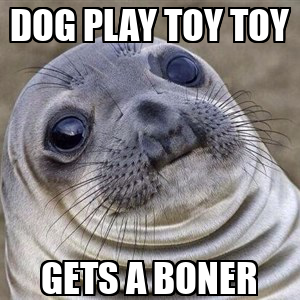

In [90]:
w_lstm_model.cuda()

get_a_meme(
    model=w_lstm_model, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=None, 
    mode='word',
    device='cuda'
)

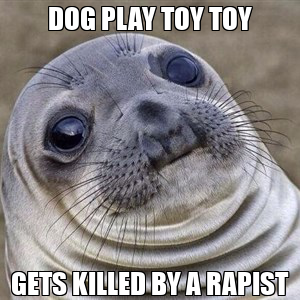

In [86]:
w_lstm_model_labels.cuda()

get_a_meme(
    model=w_lstm_model_labels, T=1.3, 
    beam_size=10,
    top_k=100,
    img_torch=img_torch, 
    img_pil=img_pil, 
    caption=caption, 
    labels=labels, 
    mode='word',
    device='cuda'
)

In [82]:
!pip install nltk

In [60]:
nltk.download('punkt')
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [61]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [62]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [69]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [88]:

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords 
from nltk.corpus import wordnet

from IPython.display import display
lemmatizer = nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 
#word tokenizeing and part-of-speech tagger
document = 'a dog is playing with a toy toy '
tokens = nltk.word_tokenize(document)
tokens = [w for w in tokens if not w in stop_words]
postag = nltk.pos_tag(tokens)

# Rule for NP chunk and VB Chunk
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        {<RB.?>*<VB.?>*<JJ>*<VB.?>+<VB>?} # Verbs and Verb Phrases
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        
"""
#Chunking
cp = nltk.RegexpParser(grammar)

# the result is a tree
tree = cp.parse(postag)

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() =='NP'):
        yield subtree.leaves()
        
def get_word_postag(word):
    if pos_tag([word])[0][1].startswith('J'):
        return wordnet.ADJ
    if pos_tag([word])[0][1].startswith('V'):
        return wordnet.VERB
    if pos_tag([word])[0][1].startswith('N'):
        return wordnet.NOUN
    else:
        return wordnet.NOUN
    
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    postag = get_word_postag(word)
    word = lemmatizer.lemmatize(word,postag)
    
    return word

def get_terms(tree):    
    for leaf in leaves(tree):
        
        terms = [normalise(w) for w,t in leaf]
        yield terms

terms = get_terms(tree)

features = ""

for term in terms:
    _term = ''
    for word in term:
        _term += ' ' + word
    features+=_term
features.lstrip()


'dog play toy toy'